In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()
base_dir = os.getenv('BASE_DIR')

In [2]:
data = np.concatenate([
    np.load(os.path.join(base_dir, f'seq_data/20words/seq_npy_1727115433_20_10.npy')),
    np.load(os.path.join(base_dir, f'seq_data/20words/seq_npy_flip_1727115434_20_10.npy')),
    np.load(os.path.join(base_dir, f'seq_data/20words/seq_npy_shift_1727115434_20_10.npy')),
    np.load(os.path.join(base_dir, f'seq_data/20words/seq_npy_flip_shift_1727115435_20_10.npy')),
], axis=0)

print(data.shape)
# (프레임 수, 시퀀스 길이, 한 프레임당 데이터 개수)

(13656, 20, 235)


In [3]:
from setting import actions
from keras.utils import to_categorical

# 데이터 분리 및 전처리
x_data = data[:, :, :-1]    # 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
labels = data[:, 0, -1]     # 마지막 요소는 레이블 값

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))

print(x_data.shape, labels.shape, y_data.shape)     # y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]
print(np.unique(labels))    # 레이블 값 출력


(13656, 20, 234) (13656,) (13656, 20)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


In [4]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할 (학습 데이터와 검증 데이터만 사용)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=21, stratify=labels)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(10924, 20, 234) (10924, 20)
(2732, 20, 234) (2732, 20)


In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 모델 정의
model = Sequential([
    LSTM(256, activation='tanh', input_shape=x_data.shape[1:3]),
    Dropout(0.3),
    Dense(len(actions), activation='softmax')
])

# 모델 컴파일 (최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               502784    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 20)                5140      
                                                                 
Total params: 507924 (1.94 MB)
Trainable params: 507924 (1.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 훈련
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, mode='auto'),
        # # early stopping 적용
        # EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ]
)

Epoch 1/100


340/342 [============================>.] - ETA: 0s - loss: 1.3283 - accuracy: 0.5611
Epoch 1: val_accuracy improved from -inf to 0.72401, saving model to models\model.keras
342/342 [==============================] - 12s 29ms/step - loss: 1.3257 - accuracy: 0.5619 - val_loss: 0.7778 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 2/100
340/342 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.7706
Epoch 2: val_accuracy improved from 0.72401 to 0.83565, saving model to models\model.keras
342/342 [==============================] - 9s 27ms/step - loss: 0.6770 - accuracy: 0.7708 - val_loss: 0.4906 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 3/100
341/342 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.8306
Epoch 3: val_accuracy did not improve from 0.83565
342/342 [==============================] - 10s 28ms/step - loss: 0.4938 - accuracy: 0.8306 - val_loss: 0.4698 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 4/100
341/342 [===================

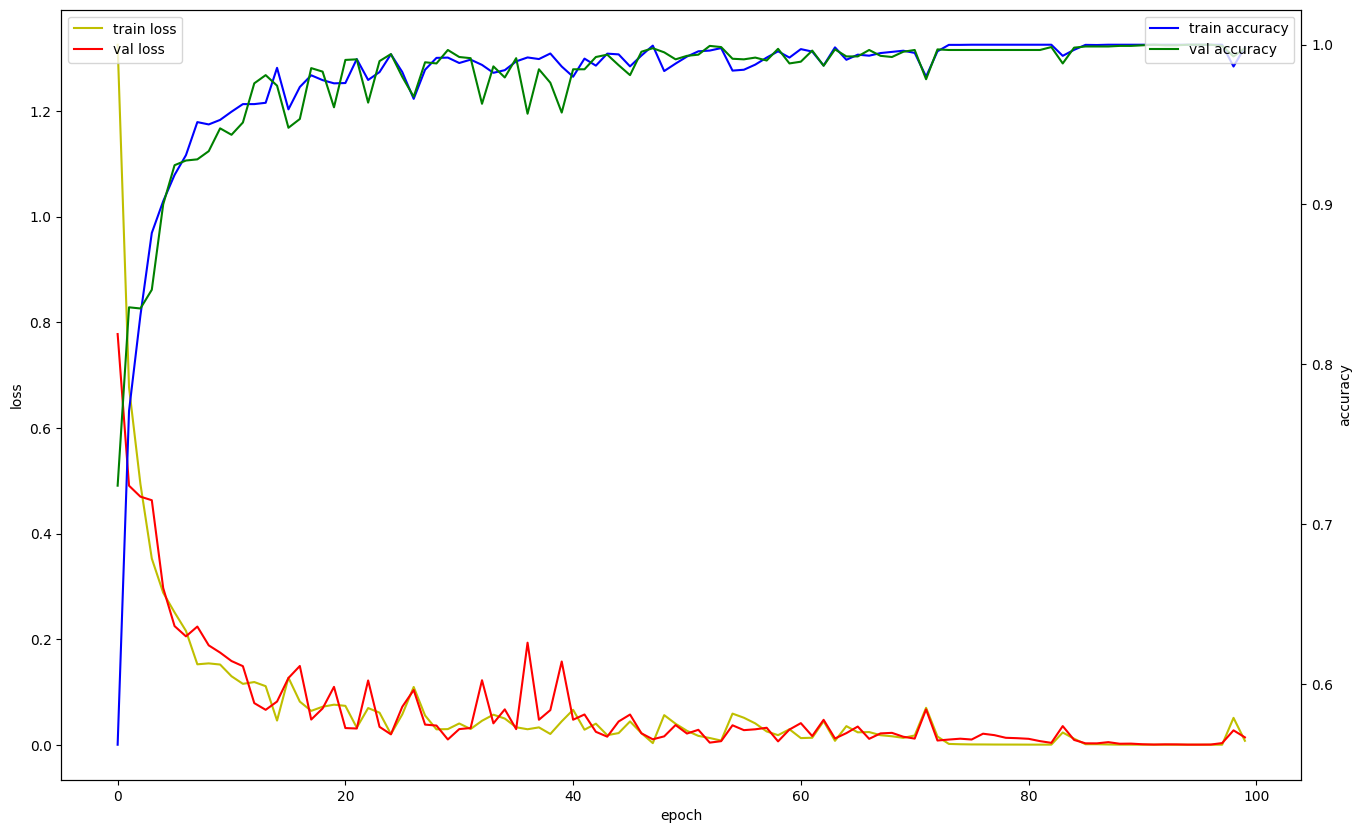

In [7]:
import matplotlib.pyplot as plt

# 학습 데이터/검증 데이터 정확도/손실 그래프
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()